## Train Tennis Notebook

The essential steps to this are:

* Define Unity environment
* Get the default brain
* Import DDPG Actor-Critic Framework
* Run DDPG training loop with default brain

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import Agents
import torch
from collections import deque
import matplotlib.pyplot as plt

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux_NoVis/Tennis.x86_64", worker_id=30)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0.       # L2 weight decay
UPDATE_EVERY = 40        # At every multiple of this value, we update our actor and critic
NUM_ITERS_LEARN = 20     # When we finally do the update, we run the learning process this many times
FC1_UNITS = 600         # Number of hidden units for the first hidden layer of the Actor and Critic networks
FC2_UNITS = 400         # Number of hidden units for the second hidden layer of the Actor and Critic networks

config = {'batch_size': BATCH_SIZE, 'buffer_size': BUFFER_SIZE, 'gamma': GAMMA,
'tau': TAU, 'lr_actor': LR_ACTOR, 'lr_critic': LR_CRITIC, 'weight_decay': WEIGHT_DECAY,
'update_every': UPDATE_EVERY, 'num_iters_learn': NUM_ITERS_LEARN, 'fc1_units': FC1_UNITS,
'fc2_units': FC2_UNITS}

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# size of each observation
states = env_info.vector_observations
state_size = states.shape[1]

# Initialise Agents
agent = Agents(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=1234, config=config)

Using user-defined parameters
{'batch_size': 128,
 'buffer_size': 1000000,
 'fc1_units': 600,
 'fc2_units': 400,
 'gamma': 0.99,
 'lr_actor': 0.0001,
 'lr_critic': 0.001,
 'num_iters_learn': 20,
 'tau': 0.001,
 'update_every': 40,
 'weight_decay': 0.0}


In [6]:
print(f'Number of agents: {num_agents}')
print(f'Action size: {action_size}')
print(f'State size: {state_size}')

Number of agents: 2
Action size: 2
State size: 24


In [7]:
## Training function for DDPG
SAVE_DIR = 'checkpoints_tennis'
import os
try:
    os.makedirs(SAVE_DIR)
except:
    pass

def ddpg(n_episodes=10000, max_t=500, print_every=100, min_score=0.5):
    """DDPG Learning via Actor-Critic
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode - 0 is to iterate until the episode is signalled done
        min_score (float): the minimum score needed over the most recent 100 episodes to pass the environment
    """
    scores_episode = []                # list containing scores from each episode
    scores_mean_episode = []
    scores_window = deque(maxlen=100)  # last 100 scores

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()                                          # resetting the noise process

        t = 0
        while True:
            t += 1
            if t == max_t:
                break
            actions = agent.act(states)                        # decide on the action
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to the environment

            next_states = env_info.vector_observations           # get next state (for each agent)
            rewards = np.array(env_info.rewards)                 # get reward (for each agent)
            dones = np.array(env_info.local_done, dtype=np.bool) # see if episode finished

            # Perform the learning step
            agent.step(states, actions, rewards, next_states, dones)
            
            scores += np.array(env_info.rewards)               # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if any episode has finished
                break

        scores_window.append(np.max(scores))               # save most recent maximuum score over the agents
        scores_episode.append(np.max(scores))              # save most recent maximum score over the agents
        scores_mean_episode.append(np.mean(scores_window))

        print('\rEpisode {}\t# of timesteps needed: {}\tMax Score: {:.2f}\t  Average Score in Window: {:.2f}'.format(i_episode, t + 1, np.max(scores), np.mean(scores_window)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\t# of timesteps needed: {}\tMax Score: {:.2f}\t  Average Score in Window: {:.2f}'.format(i_episode, t + 1, np.max(scores), np.mean(scores_window)))
        if np.mean(scores_window) >= min_score:  # To deem this a success, we must achieve an average score of 0.5 in a 100 episode window
            print('\nEnvironment solved in {:d} episodes!\tMax Score: {:.2f}\t  Average Score in Window: {:.2f}'.format(i_episode-100, np.max(scores), np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), os.path.join(SAVE_DIR, 'checkpoint_actor.pth'))
            torch.save(agent.critic_local.state_dict(), os.path.join(SAVE_DIR, 'checkpoint_critic.pth'))
            break
    
    # If we don't converge, save it anyway
    if np.mean(scores_window) < min_score:
        print(f'Note: DDPG Agent did not solve after {n_episodes} episodes')
        torch.save(agent.actor_local.state_dict(), os.path.join(SAVE_DIR, 'checkpoint_actor.pth'))
        torch.save(agent.critic_local.state_dict(), os.path.join(SAVE_DIR, 'checkpoint_critic.pth'))

    return scores_episode, scores_mean_episode

In [8]:
scores, scores_mean_episode = ddpg(n_episodes=10000)

Episode 100	# of timesteps needed: 15	Max Score: 0.00	  Average Score in Window: 0.01
Episode 200	# of timesteps needed: 15	Max Score: 0.00	  Average Score in Window: 0.00
Episode 300	# of timesteps needed: 14	Max Score: 0.00	  Average Score in Window: 0.00
Episode 400	# of timesteps needed: 15	Max Score: 0.00	  Average Score in Window: 0.00
Episode 500	# of timesteps needed: 16	Max Score: 0.00	  Average Score in Window: 0.00
Episode 600	# of timesteps needed: 15	Max Score: 0.00	  Average Score in Window: 0.00
Episode 700	# of timesteps needed: 15	Max Score: 0.00	  Average Score in Window: 0.00
Episode 800	# of timesteps needed: 15	Max Score: 0.00	  Average Score in Window: 0.00
Episode 900	# of timesteps needed: 15	Max Score: 0.00	  Average Score in Window: 0.00
Episode 1000	# of timesteps needed: 15	Max Score: 0.00	  Average Score in Window: 0.00
Episode 1100	# of timesteps needed: 16	Max Score: 0.00	  Average Score in Window: 0.01
Episode 1200	# of timesteps needed: 16	Max Score: 0.

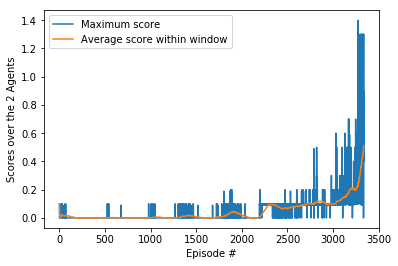

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(scores)), scores_mean_episode)
plt.ylabel('Scores over the 2 Agents')
plt.xlabel('Episode #')
plt.legend(['Maximum score', 'Average score within window'])
plt.show()